In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
import os
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import copy

## Deep SVDD objects

### Network

In [2]:
class DeepSVDD_model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, n_layers, nu, lambda_reg = 1, linear_activation = False, soft_variation = False):
        super(DeepSVDD_model, self).__init__()
        
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.n_layers = n_layers
        self.nu = nu
        self.lambda_reg = lambda_reg
        self.linear_activation = linear_activation
        self.soft_variation = soft_variation
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.linear_activation:
            self.activation = lambda x: x
        
        else:
            self.activation = nn.ReLU()
            
        #Define the network
        net_list = []
        
        for i in range(self.n_layers):
            
            if i == 0:
                net_list.append(nn.Linear(in_features = self.in_features,
                                         out_features = self.hidden_features,
                                         bias = False))
            
            if i == self.n_layers - 1:
                net_list.append(nn.Linear(in_features = self.hidden_features,
                                         out_features = self.out_features,
                                         bias = False))
        
            else:
                net_list.append(nn.Linear(in_features = self.hidden_features,
                                         out_features = self.hidden_features,
                                         bias = False))
        
        self.net_list = net_list
        
        self.network = nn.Sequential(*self.net_list)
        
        self.centre = nn.parameter.Parameter(torch.empty((1,self.out_features)),
                                        requires_grad = False)
        
        if self.soft_variation: #Requires radius
            self.squared_R = nn.Parameter(torch.ones(1),
                                            requires_grad = True)
        
        else:
            self.squared_R = nn.Parameter(torch.zeros((1)),
                                            requires_grad = False)
    
    def forward(self, x):
        
        z = self.activation(self.network(x))
        
        return z
    
    def compute_errors(self, z):
        
        z -= self.centre

        errors = torch.sum(z.pow(2), dim = 1)

        errors -= self.squared_R
                
        return errors
    
    def compute_HIs(self, x):
        
        with torch.no_grad():
            
            z = self.forward(x)
            return self.compute_errors(z)
            

### Loss object

In [3]:
class DeepSVDD_Loss(nn.Module):
    
    def __init__(self):
        
        super(DeepSVDD_Loss, self).__init__()
        
    def forward(self, model, z):
        
        if model.soft_variation:
            #term 1 - R^2 (soft variation)
            term1 = model.squared_R
        
        else:
            #term1 - 0 (only healthy data)
            term1 = 0
            
        #term2 - average inlier distance from ||f(X) - C||_2^2 - R^2 (last part is dependent on the formulation)
        term2_errors = model.compute_errors(z)
        term2 =(1 / (model.nu)) * torch.mean(term2_errors)

        #term 3 - L2 regularisation on vector (same for both)
        term3 = 0

        for param in model.network.parameters():
            term3 += torch.linalg.matrix_norm(param, ord = "fro")**2 #matrix_norm will work as we dont have any biases

        term3 *= model.lambda_reg/2

        total_loss = term1 + term2 + term3

        return total_loss

### Optimiser object

In [4]:
class DeepSVDD_optimiser(nn.Module):
    
    def __init__(self, model, learning_rate = 1e-3):
        
        super(DeepSVDD_optimiser, self).__init__()
        self.soft_variation = model.soft_variation
        
        #Network
        self.net_opt = torch.optim.Adam(model.network.parameters(), lr = learning_rate)
        
        if self.soft_variation:
            self.r_opt = torch.optim.Adam([model.squared_R], lr = learning_rate)

    def step_net(self):
        
        self.net_opt.step()
    
    def step_R(self):
        
        self.r_opt.step()
    
    def zero_grad(self):
        
        self.net_opt.zero_grad()
        
        if self.soft_variation:
            self.r_opt.zero_grad()

### Trainer object

In [5]:
class DeepSVDD_trainer(object):
    
    def __init__(self, OC_NN_model, OC_NN_optimiser, OC_NN_cost, training_iterator, valid_iterator, epochs):
        
        self.model = OC_NN_model
        self.optimiser = OC_NN_optimiser
        self.cost = OC_NN_cost
        self.train_iterator = training_iterator #Fix this later
        self.valid_iterator = valid_iterator #Fix this later
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def optimise(self, z, r_step = False, update = True):
        
        loss = self.cost(self.model, z)
        
        if update:
            loss.backward()

            if r_step:
                self.optimiser.step_R()

            else:
                self.optimiser.step_net()

            self.optimiser.zero_grad()

        return loss.detach().cpu().numpy()
    
    def train_model(self):
        
        cost_train_list = []
        cost_valid_list = []
        min_loss = np.inf
        pbar = tqdm(total = self.epochs, desc = "Cost at epoch {}: {}".format(0, np.inf))
        
        self.current_epoch_no = 0
        
        #Initialise c
        c = torch.empty((1,model.out_features)).to(self.device)
        N = 0
        for data in self.train_iterator:
            if isinstance(data, tuple): #Check to see if the input is a tuple with labels

                #Separate data
                Xdata = data[0].to(self.device)
                labels = data[1].to(self.device)

            else:
                #Push to GPU
                Xdata = data.to(self.device)
                labels = None
            
            with torch.no_grad():
                z = model.forward(Xdata)
                c += torch.sum(z, dim = 0, keepdim = True)
                N += Xdata.size(0)
        
        c /= N
        
        model.centre.data = c 
            
        #Train the model
        cnt_r = 0
        
        for i in range(self.epochs):
            
            cost_train = 0
            radius_train = 0
            cnt_train = 0
            self.model.train()
            
            #Extract data sample (Fix here!)
            #if self.train_iterator.random_seed: #Extracts random samples from the trainer
            #    print("Random iterator is not implemented.")
            #   raise SystemExit

            #elif not self.train_iterator.random_seed: #Sequentially loops through data
            
            if cnt_r != 5:
                
                for data in self.train_iterator:
                    if isinstance(data, tuple): #Check to see if the input is a tuple with labels

                        #Separate data
                        Xdata = data[0].to(self.device)
                        labels = data[1].to(self.device)

                    else:
                        #Push to GPU
                        Xdata = data.to(self.device)
                        labels = None


                    #Train step 1 - update network
                    z = self.model.forward(Xdata)
                    cost_train += self.optimise(z, r_step = False)
                    radius_train += self.model.squared_R.data.cpu().numpy()
                    
                    cnt_train += 1

                #Save
                cost_train_list.append([cost_train / cnt_train, radius_train / cnt_train])
                
                if self.model.soft_variation:
                    cnt_r += 1
            else:
                
                for data in self.train_iterator:
                    if isinstance(data, tuple): #Check to see if the input is a tuple with labels

                        #Separate data
                        Xdata = data[0].to(self.device)
                        labels = data[1].to(self.device)

                    else:
                        #Push to GPU
                        Xdata = data.to(self.device)
                        labels = None


                    #Train step 1 - update network
                    z = self.model.forward(Xdata)
                    cost_train += self.optimise(z, r_step = True)
                    radius_train += self.model.squared_R.data.cpu().numpy()
                    
                    cnt_train += 1

                #Save
                cost_train_list.append([cost_train / cnt_train, radius_train / cnt_train])
                    
                cnt_r = 0
                
            #Validation set
            cost_valid = 0
            radius_valid = 0
            cnt_valid = 0
            self.model.eval()
            
            for data in self.valid_iterator:
                
                if isinstance(data, tuple): #Check to see if the input is a tuple with labels

                    #Separate data
                    Xdata = data[0].to(self.device)
                    labels = data[1].to(self.device)

                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    labels = None
                
                cost_valid += self.optimise(z, r_step = False, update = False)
                radius_valid += self.model.squared_R.data.cpu().numpy()
                cnt_valid += 1
            
            #Save
            cost_valid_list.append([cost_valid / cnt_valid, radius_valid / cnt_valid])
            
            #Store optimal
            if cost_valid_list[-1][0] < min_loss:
                min_loss = cost_valid_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = copy.deepcopy(self.model.state_dict()) #Save the optimal state dict
                self.index_min_valid = i
            
            pbar.set_description(desc = "train/valid cost: {}/{}, radius: {}".format(cost_train_list[-1][0], cost_valid_list[-1][0], cost_train_list[-1][1]))
            pbar.update(1)
            
            
        
        pbar.close()
        
        self.min_loss = min_loss
        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list
        
        self.model.eval()
            
    def plotter(self):
        
        v1 = np.array(self.train_cost)
        v2 = np.array(self.valid_cost)
        
        fig, ax = plt.subplots(1, 1, figsize = (12, 10))
        
        ax.set_title("Training curves")
        ax.plot(v1[:, 0], label = "Total loss")
        ax.plot(v1[:, 1], label = "Radius")
        ax.plot(v2[:, 0], label = "Total loss (validation)")
        ax.plot(v2[:, 1], label = "Radius (validation)")
        ax.scatter([self.index_min_valid] * v1.shape[1], v1[self.index_min_valid, :], marker = "x", color = "r", label = "minimum train index")
        ax.scatter([self.index_min_valid] * v1.shape[1], v2[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax.legend()

        ax.grid()
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost")
            
        fig.tight_layout()
        plt.show()
        

## Create a dataset

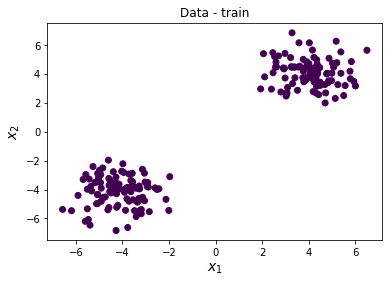

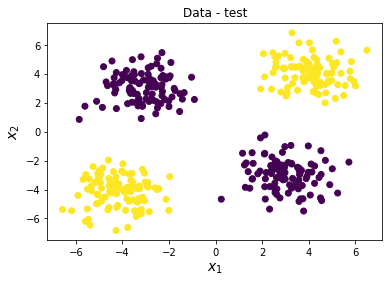

In [6]:
X1 = np.random.randn(100, 2) + np.array([4, 4])
X2 = np.random.randn(100, 2) + np.array([-4, -4])
X3 = np.random.randn(100, 2) + np.array([-3, 3])
X4 = np.random.randn(100, 2) + np.array([3, -3])

#For validation
X5 = np.random.randn(100, 2) + np.array([4, 4])
X6 = np.random.randn(100, 2) + np.array([-4, -4])

l1 = np.ones(100)
l2 = np.ones(100)

X_train = np.vstack((X1, X2))
labels_train = np.hstack((l1, l2))

X_valid = np.vstack((X5, X6))

X_test = np.vstack((X1, X2, X3, X4))
labels_test = np.hstack((l1, l2, -l1, -l2))

plt.figure()
plt.title("Data - train")
plt.scatter(X_train[:, 0], X_train[:, 1], c = labels_train)
plt.xlabel(r"$x_1$", fontsize = 14)
plt.ylabel(r"$x_2$", fontsize = 14)
plt.show()

plt.figure()
plt.title("Data - test")
plt.scatter(X_test[:, 0], X_test[:, 1], c = labels_test)
plt.xlabel(r"$x_1$", fontsize = 14)
plt.ylabel(r"$x_2$", fontsize = 14)
plt.show()

train_dataloader = DataLoader(X_train.astype('float32'), batch_size=64, shuffle=True)
valid_dataloader = DataLoader(X_valid.astype('float32'), batch_size=64, shuffle=False)
test_dataloader = DataLoader(X_test.astype('float32'), batch_size=64, shuffle=False)

## Initialise a model

In [23]:
#Define model
in_features = X_train.shape[1]
model = DeepSVDD_model(in_features = in_features, 
                   hidden_features = 64,
                   out_features = 2, 
                   n_layers = 5, 
                   nu = 0.01, 
                   lambda_reg = 0.1,   
                   linear_activation = False,
                   soft_variation = True)

#Push to GPU
model.to(model.device)

#Deine optimiser
deepsvdd_opt = DeepSVDD_optimiser(model, learning_rate = 1e-4)

#Define cost
deepsvdd_cost = DeepSVDD_Loss()

#Define trainer
my_trainer = DeepSVDD_trainer(model, deepsvdd_opt, deepsvdd_cost, train_dataloader, valid_dataloader, 100)

## Train a model


Cost at epoch 0: inf:   0%|                                                                    | 0/100 [00:00<?, ?it/s]
train/valid cost: [-93.1455]/[-84.24516], radius: [1.]:   0%|                                  | 0/100 [00:00<?, ?it/s]
train/valid cost: [-93.23187]/[-86.12724], radius: [1.]:   1%|▎                        | 1/100 [00:00<00:07, 13.74it/s]
train/valid cost: [-93.30091]/[-86.036026], radius: [1.]:   2%|▍                       | 2/100 [00:00<00:05, 19.09it/s]
train/valid cost: [-93.30091]/[-86.036026], radius: [1.]:   3%|▋                       | 3/100 [00:00<00:03, 28.36it/s]
train/valid cost: [-93.19449]/[-83.11888], radius: [1.]:   3%|▊                        | 3/100 [00:00<00:03, 28.36it/s]
train/valid cost: [-93.33531]/[-85.599075], radius: [1.]:   4%|▉                       | 4/100 [00:00<00:03, 28.36it/s]
train/valid cost: [-93.34601]/[-85.59746], radius: [1.00025]:   5%|█                   | 5/100 [00:00<00:03, 28.36it/s]
train/valid cost: [-93.34601]/[-85.5974

train/valid cost: [-94.16002]/[-86.73773], radius: [1.0032005]:  49%|████████▎        | 49/100 [00:01<00:01, 27.57it/s]
train/valid cost: [-94.15457]/[-86.45708], radius: [1.0032005]:  50%|████████▌        | 50/100 [00:01<00:01, 27.57it/s]
train/valid cost: [-94.12884]/[-85.33312], radius: [1.0032005]:  51%|████████▋        | 51/100 [00:01<00:01, 27.57it/s]
train/valid cost: [-94.12884]/[-85.33312], radius: [1.0032005]:  52%|████████▊        | 52/100 [00:01<00:01, 27.52it/s]
train/valid cost: [-94.18818]/[-86.51026], radius: [1.0032005]:  52%|████████▊        | 52/100 [00:01<00:01, 27.52it/s]
train/valid cost: [-94.18945]/[-86.06318], radius: [1.0034505]:  53%|█████████        | 53/100 [00:01<00:01, 27.52it/s]
train/valid cost: [-94.174065]/[-84.79114], radius: [1.0036006]:  54%|████████▋       | 54/100 [00:02<00:01, 27.52it/s]
train/valid cost: [-94.174065]/[-84.79114], radius: [1.0036006]:  55%|████████▊       | 55/100 [00:02<00:01, 27.12it/s]
train/valid cost: [-94.255905]/[-86.6246

train/valid cost: [-95.02695]/[-86.2032], radius: [1.0064011]:  99%|█████████████████▊| 99/100 [00:03<00:00, 23.70it/s]
train/valid cost: [-95.02695]/[-86.2032], radius: [1.0064011]: 100%|█████████████████| 100/100 [00:03<00:00, 25.82it/s]


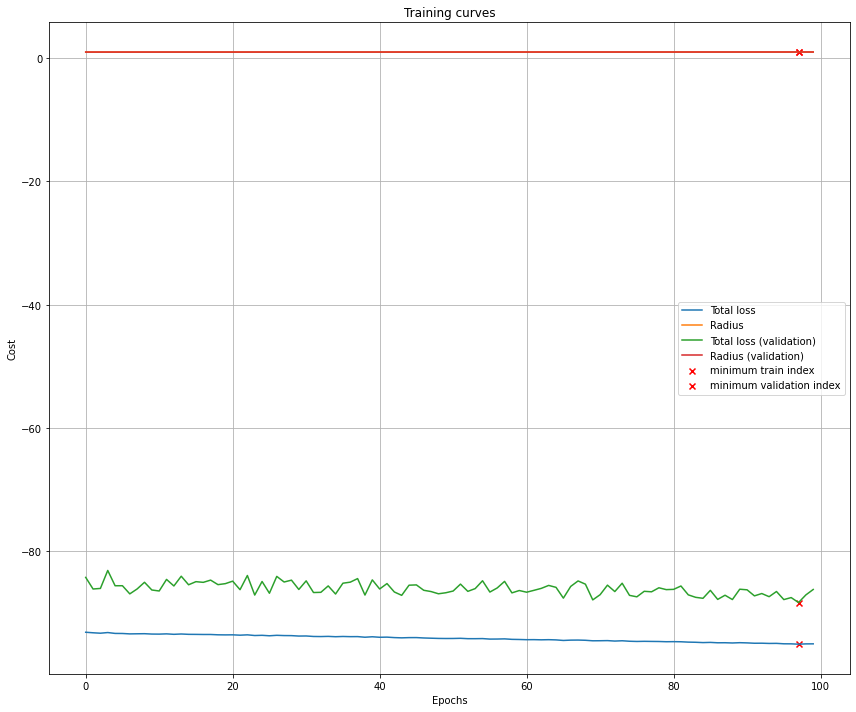

Selecting the optimal state dictionary!


In [24]:
my_trainer.train_model()

my_trainer.plotter()

if hasattr(my_trainer, "optimal_state_dict"):
    print("Selecting the optimal state dictionary!")
    model.load_state_dict(my_trainer.optimal_state_dict)

In [21]:
model.centre

Parameter containing:
tensor([[0.0102, 0.0381]], device='cuda:0')

## Test a model

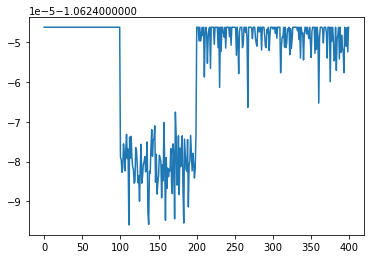

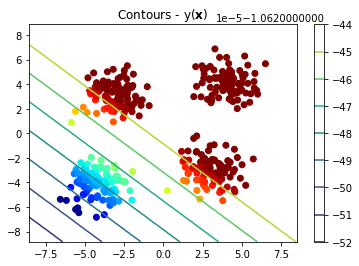

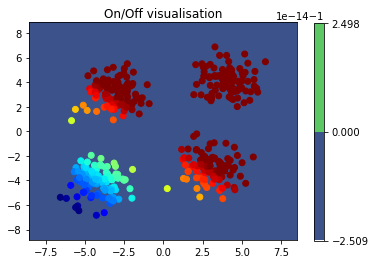

In [22]:
z_pred = np.zeros((len(labels_test), 1))
start = 0

for data in test_dataloader:
    if isinstance(data, tuple): #Check to see if the input is a tuple with labels

        #Separate data
        Xdata = data[0].to(model.device)
        labels = data[1].to(model.device)

    else:
        #Push to GPU
        Xdata = data.to(model.device)
        labels = None  
    
    with torch.no_grad():
        HI = model.compute_HIs(Xdata)
        
        z_pred[start: start + Xdata.size(0), 0] = HI.cpu().numpy()
        
        start += Xdata.size(0)

plt.figure()
plt.plot(z_pred[:, 0])
plt.show()

N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X_test[:, 0]) - 2, np.max(X_test[:, 0]) + 2, N_grid), 
                       np.linspace(np.min(X_test[:, 1]) - 2, np.max(X_test[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

X_grid = torch.from_numpy(X_grid.astype('float32')).to(model.device)

with torch.no_grad():
    Z = model.compute_HIs(X_grid).cpu().numpy()

plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = z_pred, cmap = plt.cm.jet)
#plt.xlabel()
#plt.ylabel()
plt.title(r"Contours - y($\mathbf{x}$)")

plt.show()

if model.soft_variation:
    plt.figure()
    plt.contourf(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
    plt.colorbar()
    plt.scatter(X_test[:, 0], X_test[:, 1], c = z_pred, cmap = plt.cm.jet)
    #plt.xlabel()
    #plt.ylabel()
    plt.title("On/Off visualisation")
    plt.show()